# Dice sum game (Value-based)

In this example, we demonstrate how we could learn to play a game with a value-based method.

The game consists of two players, each of them throw a set of dice. They have to bet on the sum of all dice on the table by looking at only their dice.

## The environment

First, we need to define the environment. Here we implement the dice sum game using the `gym` library from [OpenAI](https://gym.openai.com/).

In [0]:
import gym
from gym import spaces
import random
import pandas as pd
import numpy as np


class DiceSumEnv(gym.Env):
  """
  Implements a simple game where 2 players throw n dice each 
  and have to guess the sum of all dice 
  without seeing the dice of the opponent
  """
  
  def __init__(self, n_dice, opponent='rand'):
    """
    :param opponent: in rand or double or an integer for constant answers
    """

    # General variables defining the environment
    self.n_dice = n_dice
    self.opponent = opponent

    # Define what the agent can do
    # It can bet on the sum from 2 * 1 * n_dice to 2 * 6 * n_dice
    # = n_dice * (6*2 - 2*1) + 1 = 10*d_dice + 1
    self.action_space = spaces.Discrete(10 * self.n_dice + 1)
    
    # Observation space
    # It sees on the sum from 1 * n_dice to 6 * n_dice
    # = n_dice * (6 - 1) + 1 = 5*d_dice + 1
    self.observation_space = spaces.Discrete(5 * self.n_dice + 1)
    
    # Initialize state
    self.agent_dice = 0
    self.opponent_dice = 0
    
    # Record guess
    self.episodes = []
  
  def step(self, action):
    real_sum = self.agent_dice + self.opponent_dice
    opponent_guess = self._opponent_guess(self.opponent_dice)
    opponent_error = abs(opponent_guess - real_sum)
    agent_error = abs(action - real_sum)
    
    if agent_error < opponent_error:
      reward = 1
    elif agent_error > opponent_error:
      reward = -1
    else:
      reward = 0
    #reward = 1 if agent_error < opponent_error else 0
    
    self.episodes.append({
        "agent_guess": action,
        "opponent_guess": opponent_guess,
        "agent_dice": self.agent_dice,
        "opponent_dice": self.opponent_dice,
        "actual_dice_sum": real_sum,
        "agent_reward": reward
    })
    
    return None, reward, True, {}
    
  def reset(self):
    self._roll_dice()
    return self.agent_dice
  
  def _roll_dice(self):
    self.agent_dice = np.random.randint(0, 6, self.n_dice).sum()
    self.opponent_dice = np.random.randint(0, 6, self.n_dice).sum()
  
  def _opponent_guess(self, opponent_dice):
    if self.opponent == 'rand':
      return random.randint(0, 10 * self.n_dice)
    elif self.opponent == 'double':
      return opponent_dice * 2
    else:
      return self.opponent - self.n_dice*2
  
  def render(self):
    df = pd.DataFrame(self.episodes)
    df[["agent_reward"]].rolling(200).sum().plot(figsize=(10, 8))

## Baseline agent

This agent plays random moves and is only used as baselines

In [0]:
import itertools

def random_player(env, num_episodes):
  for ith_episode in range(num_episodes): 
    
    # Reset the environment and pick the first action 
    state = env.reset() 

    for t in itertools.count():
      action = env.action_space.sample()
      
      # take action and get reward, transit to next state 
      next_state, reward, done, _ = env.step(action)
      
      if done: 
          break

      state = next_state


## Q-Learner agent

This agent uses the Q-Learning algorithm with an epsilon greedy policy. The parameter epsilon controls exploration and will, with a probability epsilon select next state randomly.

Inspired by https://www.geeksforgeeks.org/q-learning-in-python/

In [0]:
from collections import defaultdict
import itertools
import numpy as np

# Q Learning

def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction 


def qLearning(env, num_episodes, discount_factor = 1.0, 
                            alpha = 0.005, epsilon = 0.1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy"""
       
    # Action value function 
    # A nested dictionary that maps 
    # state -> (action -> action-value). 
    Q = defaultdict(
        lambda: np.random.rand(env.action_space.n)/env.action_space.n
    )
       
    # Create an epsilon greedy policy function 
    # appropriately for environment action space 
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n) 
       
    # For every episode 
    for ith_episode in range(num_episodes): 
           
        # Reset the environment and pick the first action 
        state = env.reset() 
           
        for t in itertools.count(): 
               
            # get probabilities of all actions from current state 
            action_probabilities = policy(state) 
   
            # choose action according to  
            # the probability distribution 
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities) 
   
            # take action and get reward, transit to next state 
            next_state, reward, done, _ = env.step(action)
               
            # TD Update 
            best_next_action = np.argmax(Q[next_state])     
            td_target = reward + discount_factor * Q[next_state][best_next_action] 
            td_delta = td_target - Q[state][action] 
            Q[state][action] += alpha * td_delta 
   
            # done is True if episode terminated    
            if done: 
                break
                   
            state = next_state 
       
    return Q#, stats 


## Utils functions

The following functions allow us to plot the performance of the agent over time as well as the learnt matrix Q

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns


def render_comparison(rand_game, q_game, win_size=5000):
  df = pd.DataFrame([
      {"reward_rand": x[0]["agent_reward"], "reward_q": x[1]["agent_reward"]}
      for x in zip(rand_game.episodes, q_game.episodes)
  ])/win_size
  df.rolling(win_size).sum().plot(figsize=(15, 6))


def render_matrix_q(q, n_dice):
  grid = pd.DataFrame(
      [q[x] for x in range(n_dice*5+1)], 
      index=range(n_dice, n_dice*6+1), 
      columns=range(n_dice*2, n_dice*2*6+1)
  )

  plt.figure(figsize=(15, 8))
  cmap = sns.diverging_palette(20, 220, sep=20, as_cmap=True)
  sns.heatmap(grid, linewidths='1', annot=True, cmap=cmap, center=0);

## Playing the game

In the following, we train the agent by playing the game against a player which always bets twice the sum of its own dice.

How will our agent perform?

In [0]:
N_EPISODES = 10000
N_DICE = 2
OPPONENT_TYPE = 'double' # Must rand or double or an integer

# Setting the numpy seed
np.random.seed(0)

# Random agent
dice_sum_rand = DiceSumEnv(N_DICE, opponent=OPPONENT_TYPE)
random_player(dice_sum_rand, N_EPISODES)

# Q-learner
dice_sum_q = DiceSumEnv(N_DICE, opponent=OPPONENT_TYPE)
Q = qLearning(
    dice_sum_q, 
    N_EPISODES, 
    discount_factor=0, 
    alpha=0.05, 
    epsilon=0
)

Looking at the graph below, our agent outperforms a random player.

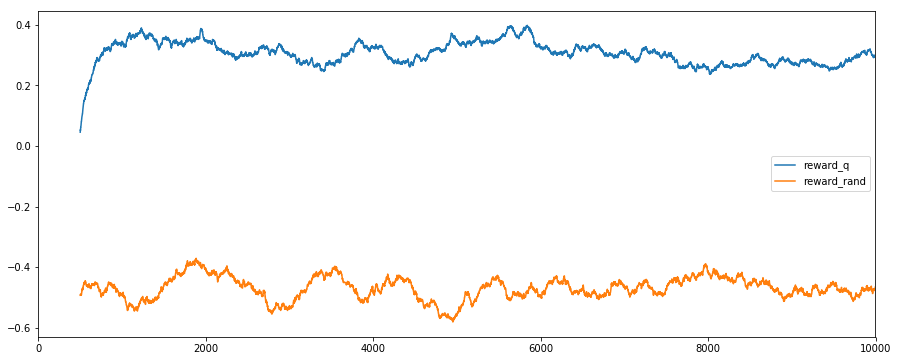

In [0]:
render_comparison(dice_sum_rand, dice_sum_q, win_size=500)

Inspecting the matrix Q helps us understand the strategy of our player.

We realise that most states/actions have a value close to 0 and a few have a positive value. This means our agent was in exploitation mode. It hasn't tried to explore and find better strategies over time.

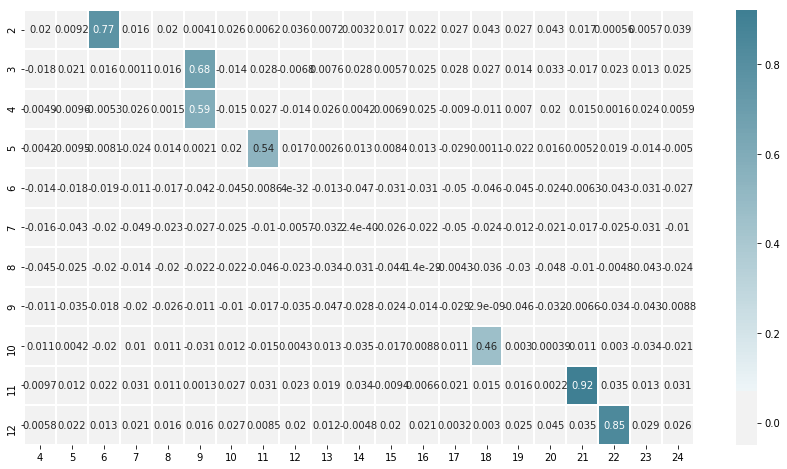

In [0]:
render_matrix_q(Q, N_DICE)

## Exploration

Changing the epsilon parameter to 10% (allowing for 10% exploration) yields a very different matrix Q where most combination of state/action has been populated.

A common practice would be to reduce the value of epsilon (reduce exploration) as our matrix Q becomes better.

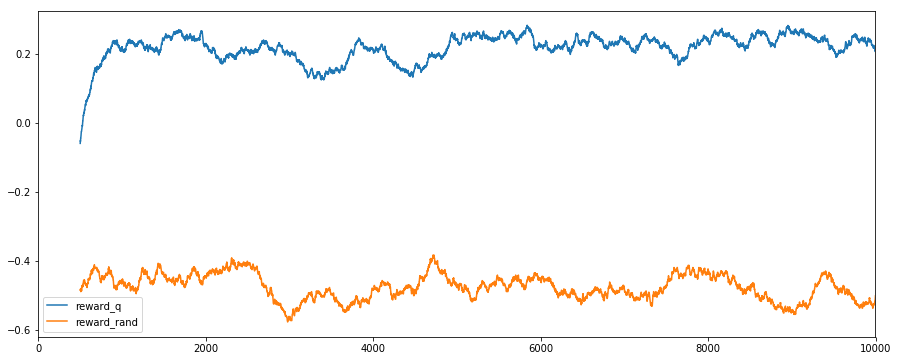

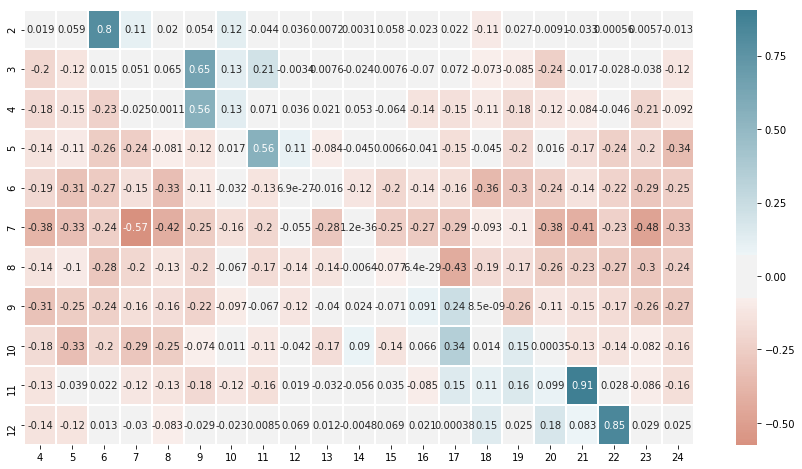

In [0]:
N_EPISODES = 10000
N_DICE = 2
OPPONENT_TYPE = 'double' # Must rand or double or an integer

# Setting the numpy seed
np.random.seed(0)

# Random agent
dice_sum_rand = DiceSumEnv(N_DICE, opponent=OPPONENT_TYPE)
random_player(dice_sum_rand, N_EPISODES)

# Q-learner
dice_sum_q = DiceSumEnv(N_DICE, opponent=OPPONENT_TYPE)
Q = qLearning(
    dice_sum_q, 
    N_EPISODES, 
    discount_factor=0, 
    alpha=0.05, 
    epsilon=0.1
)
render_comparison(dice_sum_rand, dice_sum_q, win_size=500)
render_matrix_q(Q, N_DICE)

# Trader (Policy method)

In the previous example, we could use the Q-learning approach because we could create the matrix Q which was 10x20=200. However, we don't always have 200 combination of state/actions, sometimes it is impossible to represent all combinations in one matrix.

In the following example, we consider the case of a trader. This trader is given the previous 10 prices of a stock and the advice from 5 analysts (buy/sell). The stock price can vary between 0 and 100.

The goal of the trader is to decide at each time step whether to hold his position or to sell. The reward is computed as the different between his initial investment and the price he could sell his stock.

A quick calculation gives us the size of the state space: `5*2 + 100^10 = 1e20` which is just not realistic to store on a computer for such a simple problem.

In [0]:
import gym
from gym import spaces
import random
import pandas as pd


class StockMarketEnv(gym.Env):
  """
  Simulates a simple stock market with one stock and discrete prices (0-100)
  """
  
  def __init__(self, n_analysts=5, n_stock_history=10,
              max_price=100, starting_price=20, max_time=1000):
    """
    :param opponent: in rand or double or an integer for constant answers
    """

    # General variables defining the environment
    # Number of analysts givin advices
    self.n_analysts = n_analysts  
    # Number of past stock prices in state
    self.n_stock_history = n_stock_history
    self.max_price = max_price
    self.starting_price = starting_price
    self.max_time=1000

    # Define what the agent can do: hold or sell
    self.action_space = spaces.Discrete(2)
    
    # Observation space
    # number of analysts times their position up / down
    # number of past prices for max price
    self.observation_space = spaces.MultiDiscrete(
        [2] * self.n_analysts
        + [self.max_price] * self.n_stock_history
    )
    
    # Initialize state
    self.stock_price = None
    self.p_down = None
    self.analysts_guess = None
    
    # Record guess
    self.episodes = []
  
  def reset(self):
    self.p_down = np.random.rand()
    self.stock_price = np.array([0])
    self._analysts_guess()
    for _ in range(self.n_stock_history):
      self._next_price()
    self.stock_price = self.stock_price \
      - self.stock_price[-1] + self.starting_price
    return self._get_state()
  
  def _next_price(self):
    self.stock_price = np.append(
      self.stock_price,
      [np.minimum(
          self.stock_price[-1] + ((np.random.rand() > self.p_down) * 2 - 1),
          self.max_price
      )]
    )
  
  def _analysts_guess(self):
    self.analysts_guess = np.random.binomial(1, 1-self.p_down, self.n_analysts)
  
  def _get_state(self):
    return np.append(self.analysts_guess, self.stock_price[-10:])
  
  def step(self, action):
    if action == 1 or self.max_time <= len(self.stock_price):
      # Sell
      return self._episode_end(self.stock_price[-1] - self.starting_price)
    else:
      # Hold
      self._next_price()
      if self.stock_price[-1] > 0:
        # Continue
        return self._get_state(), 0, False, {}
      else:
        # Game over, bankrupt
        return self._episode_end(-self.starting_price)
  
  def _episode_end(self, reward):
    self.episodes.append(reward)
    return None, reward, True, {}
  
  def render(self, rolling=100):
    df = pd.DataFrame({"reward": self.episodes})
    df[["reward"]].rolling(rolling).sum().plot(figsize=(10, 8))

## Naive player

The baseline trader for this scenario will implement a simple strategy: he will sell as soon as the stock goes down

In [0]:
def naive_player(env, num_episodes):
  
  for ith_episode in range(num_episodes): 
    
    # Reset the environment and pick the first action 
    state = env.reset() 

    for t in itertools.count():
      # Hold until the stock drops
      action = 0 if state[-1] - state[-2] > 0 else 1
      
      # take action and get reward, transit to next state 
      next_state, reward, done, _ = env.step(action)
      
      if done: 
          break

      state = next_state

## Policy gradient agent

To tackle the issue of the high dimensional space, we are not using a value-based approach but we will directly try to estimate the policy function. Namely, the function that decides which action to take in a given state.

To model the policy function, we use a simple neural network with input 5+10=50 features and 2 outputs (probability of hold and sell).

The idea is to collect the reward received at each episode and update the parameters of the neural network to make the actions that conducted to a reward more likely.

The following code is inspired from https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import time


class StockPolicyGradient(nn.Module):
  
  def __init__(self, env, gamma=0.99):
    super(StockPolicyGradient, self).__init__()
    self.state_space_n = env.observation_space.shape[0]
    self.action_space_n = env.action_space.n # hold or sell

    self.l1 = nn.Linear(self.state_space_n, self.action_space_n, bias=False)

    self.gamma = gamma

    # Episode policy and reward history 
    self.policy_history = torch.Tensor()
    self.reward_episode = []
    # Overall reward and loss history
    self.reward_history = []
    self.loss_history = []

  def forward(self, x):    
    model = torch.nn.Sequential(
        self.l1,
        nn.Softmax(dim=-1)
    )
    return model(x)


def norm_state(env, state):
  state = state.astype(np.float)
  state[-env.n_stock_history:] = state[-env.n_stock_history:] / 100.
  return state - 0.5

  
def select_action(policy, state):
  # Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
  state = torch.from_numpy(state).type(torch.FloatTensor)
  state = policy(state)
  c = Categorical(state)
  action = c.sample()

  # Add log probability of our chosen action to our history
  policy.policy_history = torch.cat([
    policy.policy_history, 
    c.log_prob(action).reshape(1)
  ])
  return action


def update_policy(policy, optimizer):
  R = 0
  rewards = []

  # Discount future rewards back to the present using gamma
  for r in policy.reward_episode[::-1]:
      R = r + policy.gamma * R
      rewards.insert(0,R)

  # Scale rewards
  rewards = torch.FloatTensor(rewards)
  #rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

  # Calculate loss
  loss = (torch.sum(torch.mul(policy.policy_history, rewards).mul(-1), -1))

  # Update network weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Save and intialize episode history counters
  policy.loss_history.append(loss.item())
  policy.reward_history.append(np.sum(policy.reward_episode))
  policy.policy_history = torch.Tensor()
  policy.reward_episode= []

  
def policy_gradient_player(env, num_episodes, learning_rate=0.01, gamma=0.99):
  
  # Init stock policy
  stock_policy = StockPolicyGradient(env, gamma=gamma)
  optimizer = optim.Adam(stock_policy.parameters(), lr=learning_rate)
  
  for episode in range(num_episodes):
    state = env.reset() # Reset environment and record the starting state
    done = False       

    while not done:
      action = select_action(stock_policy, norm_state(env, state))
      # Step through environment using chosen action
      state, reward, done, _ = env.step(action.item())

      # Save reward
      stock_policy.reward_episode.append(reward)

    update_policy(stock_policy, optimizer)

    if episode % 100 == 0:
      print('Episode {}'.format(episode))


## Utils functions

In [0]:
def render_policy_comparison(stock_n, stock_p, rolling=100):
  df = pd.DataFrame({
      "naive": stock_n.episodes,
      "policy": stock_p.episodes
  })
  df[["naive", "policy"]].rolling(rolling).mean().plot(figsize=(10, 8))

## Playing

As expected, the policy based trader can generate much more profit than the naive player after a few hundreds of episodes.

In [0]:
# Training naive player
np.random.seed(0)
stock_naive = StockMarketEnv()
naive_player(stock_naive, 1500)

In [0]:
import random

# Training policy gradient
stock_policy = StockMarketEnv()
policy_gradient_player(stock_policy, 1500)

Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400


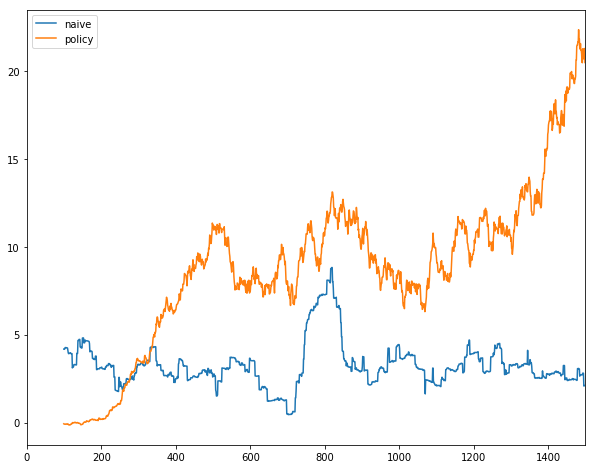

In [0]:
render_policy_comparison(stock_naive, stock_policy)

https://github.com/dennybritz/reinforcement-learning

https://colab.research.google.com/drive/17iM0vx848VYWFwW3Du-l-FCn3Y1VhCgx

https://www.freecodecamp.org/news/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe/

https://www.freecodecamp.org/news/an-introduction-to-reinforcement-learning-4339519de419/

https://www.freecodecamp.org/news/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d/